Cross-validation scores: [0.43352601 0.43023256 0.43604651 0.51162791 0.43023256 0.44767442
 0.47674419 0.49418605 0.44767442 0.44767442]
Mean cross-validation score: 0.4555619034816508


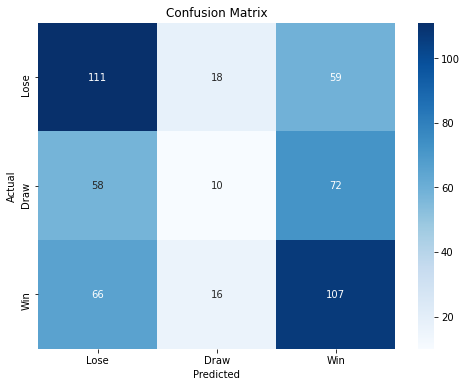

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
matches = pd.read_csv('matches_laliga.csv')

# Convert 'date' to datetime
matches['date'] = pd.to_datetime(matches['date'])

# Encoding categorical variables
encoder = LabelEncoder()
categorical_variables = ['team', 'opponent', 'venue', 'day', 'comp']
for var in categorical_variables:
    matches[var] = encoder.fit_transform(matches[var])

# Creating time-based features
matches['venue_code'] = matches['venue'].astype('category').cat.codes
matches['opp_code'] = matches['opponent'].astype('category').cat.codes
matches['hour'] = matches['time'].str.replace(":.+","", regex=True).astype('int')
matches['day_code'] = matches['date'].dt.dayofweek

# Encoding the 'result' column
matches['result'] = matches['result'].map({'W': 1, 'D': 0, 'L': -1})

# Implementing rolling averages
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('date')
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    return group.dropna(subset=new_cols)

cols = ['gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
new_cols = [f"{c}_rolling" for c in cols]
matches_rolling = matches.groupby('team').apply(lambda x: rolling_averages(x, cols, new_cols)).droplevel('team')

# Updating predictors with new features
predictors = ['venue_code', 'opp_code', 'hour', 'day_code'] + new_cols

# Creating and training the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Perform cross-validation
cv_scores = cross_val_score(model, matches_rolling[predictors], matches_rolling['result'], cv=10)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Optional: Train-test split and Confusion Matrix (if you want to visualize predictions)
X_train, X_test, y_train, y_test = train_test_split(matches_rolling[predictors], matches_rolling['result'], test_size=0.3, random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cm_labels = ['Lose', 'Draw', 'Win']

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=cm_labels, yticklabels=cm_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()